MAD Statistics

In [58]:
#Place MAD data into SBS groups
# Import Modules
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from scipy.io import loadmat
import scipy
from scipy.stats import ttest_ind, skew, ttest_rel
import Actigraph_Metrics
from pathlib import Path
import itertools


In [59]:
#data_dir = 'C:/Users/sidha/OneDrive/Sid_stuff/PROJECTS/PedAccel/data_analysis/Vitals_accel_analysis/PatientData'
data_dir = Path('/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/Ventilated_Patient_Data')
data_dir = Path('/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/PatientData_Directory_To_Have_NEW 3')
window_size = 100 #100 is 1 second worth of time
lead_time = 1
slice_size_min = 16
sr = .5
Tag = 'Retro'

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu, kruskal, wilcoxon, ks_2samp, anderson

# Cohen's d
def cohens_d(x, y):
    diff = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt((np.var(x, ddof=1) + np.var(y, ddof=1)) / 2)
    return diff / pooled_std if pooled_std > 0 else np.nan

# Hedges' g
def hedges_g(x, y):
    d = cohens_d(x, y)
    n1, n2 = len(x), len(y)
    correction_factor = 1 - (3 / (4*(n1+n2-2) - 1))
    return d * correction_factor

# Helper: plot when significant
def plot_difference(data_1, data_2, label_1, label_2, title_suffix=""):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Histogram comparison
    axs[0].hist(data_1, bins=40, alpha=0.6, label=label_1)
    axs[0].hist(data_2, bins=40, alpha=0.6, label=label_2)
    axs[0].set_title(f"Histogram {title_suffix}")
    axs[0].legend()

    # Boxplot comparison
    axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])
    axs[1].set_title(f"Boxplot {title_suffix}")

    plt.tight_layout()
    plt.show()

# Main comparison function
def compare_data(data_1, label_1, data_2, label_2):

    data_1 = np.asarray(data_1)
    data_2 = np.asarray(data_2)

    # Must have data
    if data_1.size == 0 or data_2.size == 0:
        # print(f"Skipping comparison {label_1} vs {label_2}: one array is empty")
        return []

    # Minimum sample size
    MIN_N = 30
    if len(data_1) < MIN_N or len(data_2) < MIN_N:
        # print(f"Skipping comparison {label_1} vs {label_2}: sample size < {MIN_N}")
        return []

    # Subsample for statistical stability
    MAX_N = 500
    if len(data_1) > MAX_N:
        data_1 = np.random.choice(data_1, MAX_N, replace=False)
    if len(data_2) > MAX_N:
        data_2 = np.random.choice(data_2, MAX_N, replace=False)

    # Skip constant arrays
    if np.std(data_1) == 0 or np.std(data_2) == 0:
        # print(f"Skipping comparison {label_1} vs {label_2}: one array has zero variance")
        return []

    significant_differences = []
    should_plot = False      # <- flag to trigger visualization
    plot_title = ""

    # Mann-Whitney U
    stat, p_value = mannwhitneyu(data_1, data_2, alternative='two-sided')
    if p_value < 0.05:
        significant_differences.append(f"Mann-Whitney U test: {p_value:.3e}")
        # print(f"Significant Mann-Whitney ({label_1} vs {label_2}): p={p_value:.3e}")
        should_plot = True
        # plot_title += f"MWU p={p_value:.1e}  "

    # Kruskal-Wallis
    stat, p_value = kruskal(data_1, data_2)
    if p_value < 0.05:
        significant_differences.append(f"Kruskal-Wallis test: {p_value:.3e}")
        # print(f"Significant Kruskal-Wallis ({label_1} vs {label_2}): p={p_value:.3e}")
        should_plot = True
        # plot_title += f"KW p={p_value:.1e}  "

    # Wilcoxon (only if paired)
    if len(data_1) == len(data_2):
        stat, p_value = wilcoxon(data_1, data_2)
        if p_value < 0.05:
            significant_differences.append(f"Wilcoxon test: {p_value:.3e}")
            # print(f"Significant Wilcoxon ({label_1} vs {label_2}): p={p_value:.3e}")
            should_plot = True
            # plot_title += f"Wil p={p_value:.1e}  "

    # KS Test
    stat, p_value = ks_2samp(data_1, data_2)
    if p_value < 0.05:
        significant_differences.append(f"KS test: {p_value:.3e}")
        # print(f"Significant KS ({label_1} vs {label_2}): p={p_value:.3e}")
        should_plot = True
        # plot_title += f"KS p={p_value:.1e}  "

    # Anderson-Darling (normality check)
    result_1 = anderson(data_1)
    result_2 = anderson(data_2)
    # if result_1.statistic > result_1.critical_values[2] or result_2.statistic > result_2.critical_values[2]:
        # print(f"At least one group fails normality: {label_1}, {label_2}")

    # Effect sizes
    d = cohens_d(data_1, data_2)
    if np.isfinite(d) and abs(d) > 0.5:
        significant_differences.append(f"Cohen's d: {d:.3e}")
        # print(f"Effect size: Cohen's d = {d:.3e}")
        should_plot = True
        # plot_title += f"d={d:.2f}  "

    g = hedges_g(data_1, data_2)
    if np.isfinite(g) and abs(g) > 0.5:
        significant_differences.append(f"Hedges' g: {g:.3e}")
        print(f"Effect size: Hedges' g = {g:.3e}")
        should_plot = True
        plot_title += f"g={g:.2f}  "

    # --- Visualization Trigger ---
    if should_plot:
        print(f"Plotting differences for {label_1} vs {label_2}...")
        plot_difference(data_1, data_2, label_1, label_2, plot_title)

    return significant_differences


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/3147975727.py:40: RuntimeWarning: invalid value encountered in divide
  rr_norm = (rr_data - rr_min) / (rr_max - rr_min)


skipping patient Patient11 due to load error.
skipping patient Patient15 due to load error.
6
0
0
0
0
0
20160
Plotting differences for sbs -2 HR vs sbs -1 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


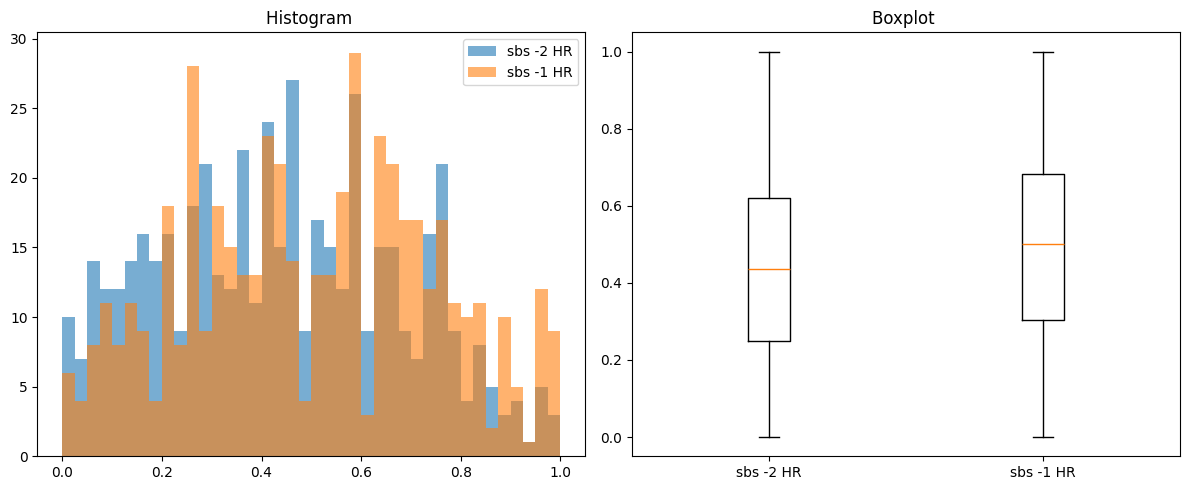

20160
20160
Plotting differences for sbs -2 HR vs sbs 1 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


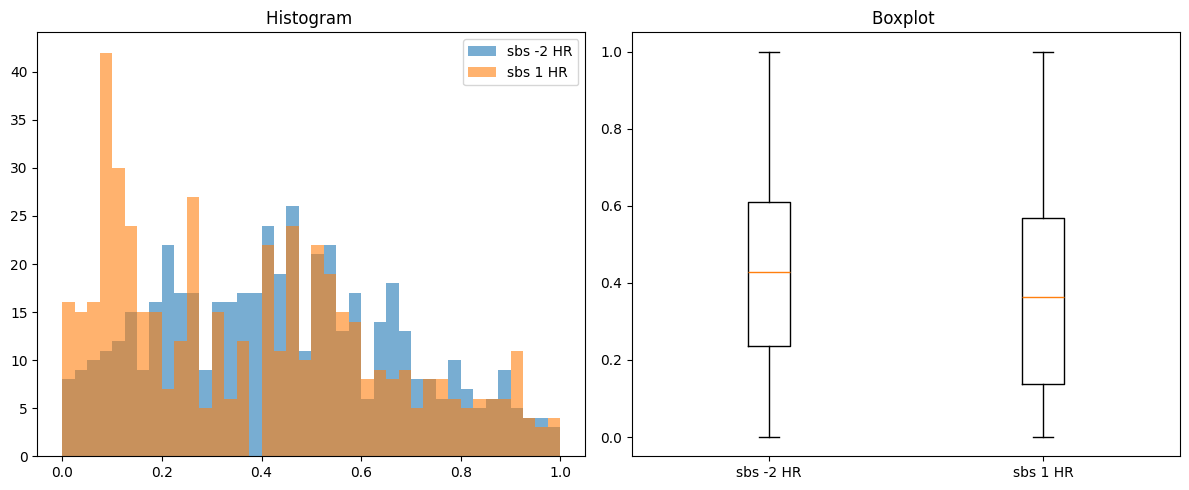

20160
16320
Plotting differences for sbs -1 HR vs sbs 0 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


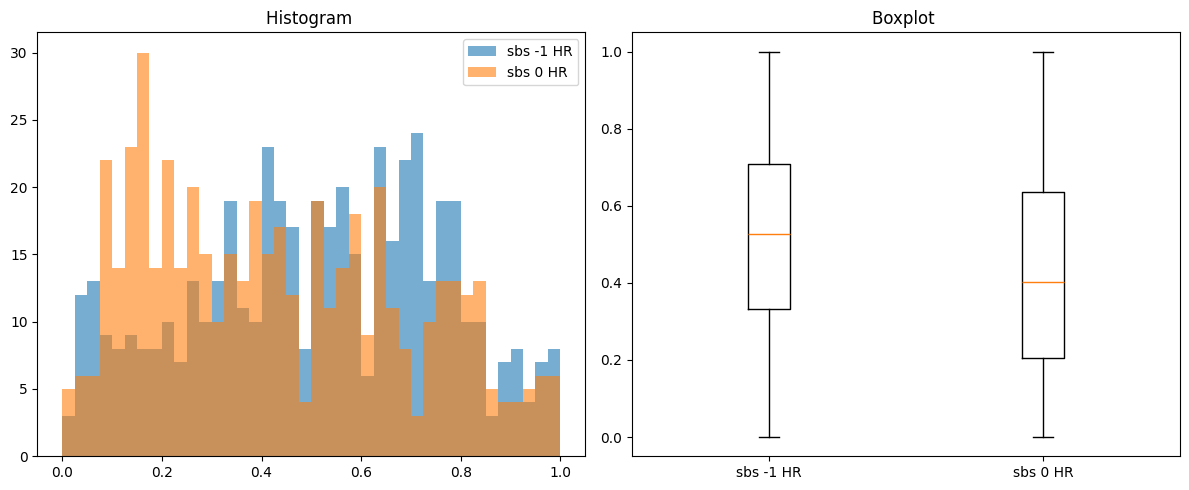

16320
Effect size: Hedges' g = 5.623e-01
Plotting differences for sbs -1 HR vs sbs 1 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


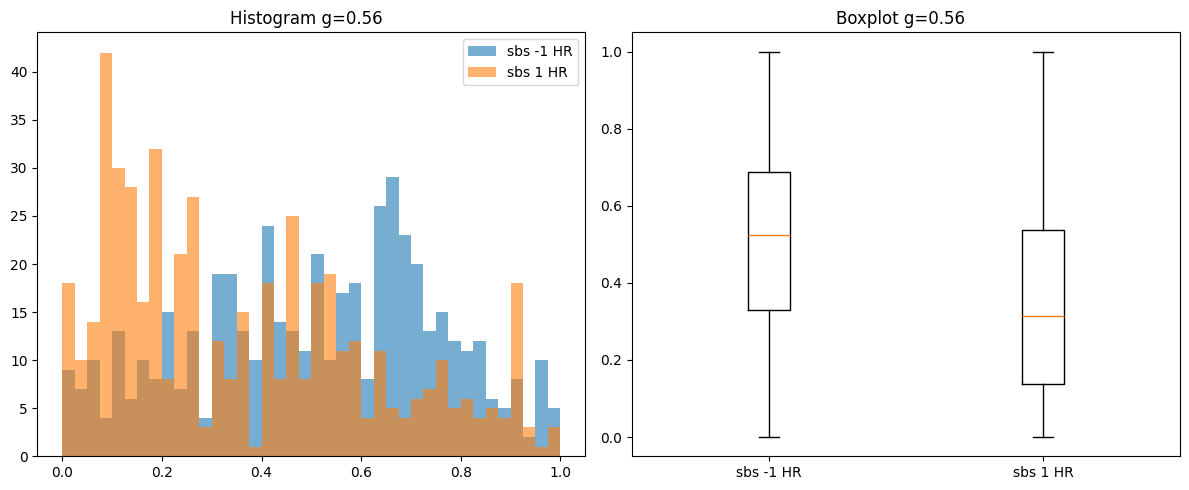

16320
92160
Plotting differences for sbs 0 HR vs sbs 1 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


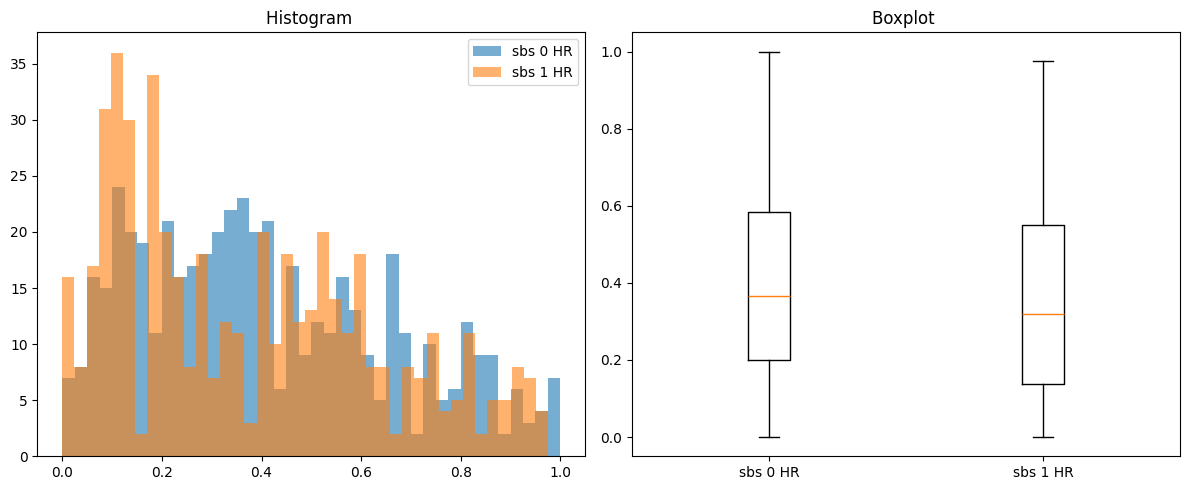

92160
1920
0
0
0
0
0
20160
20160
20160
20160
16320


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


16320
16320
92160
92160
1920
0
0
0
0
0
40320
Plotting differences for sbs -2 Accel vs sbs -1 Accel...


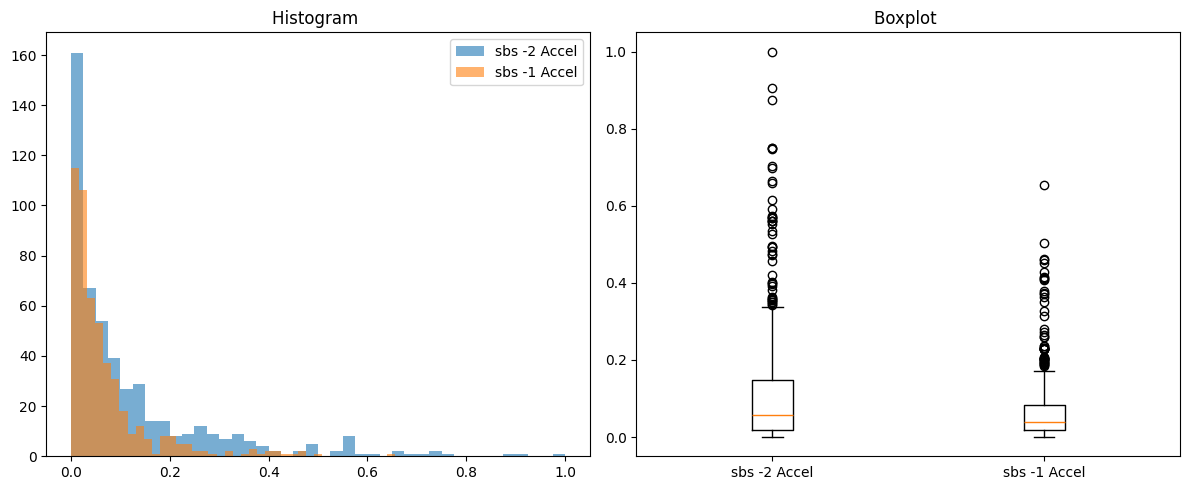

40320
Plotting differences for sbs -2 Accel vs sbs 0 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


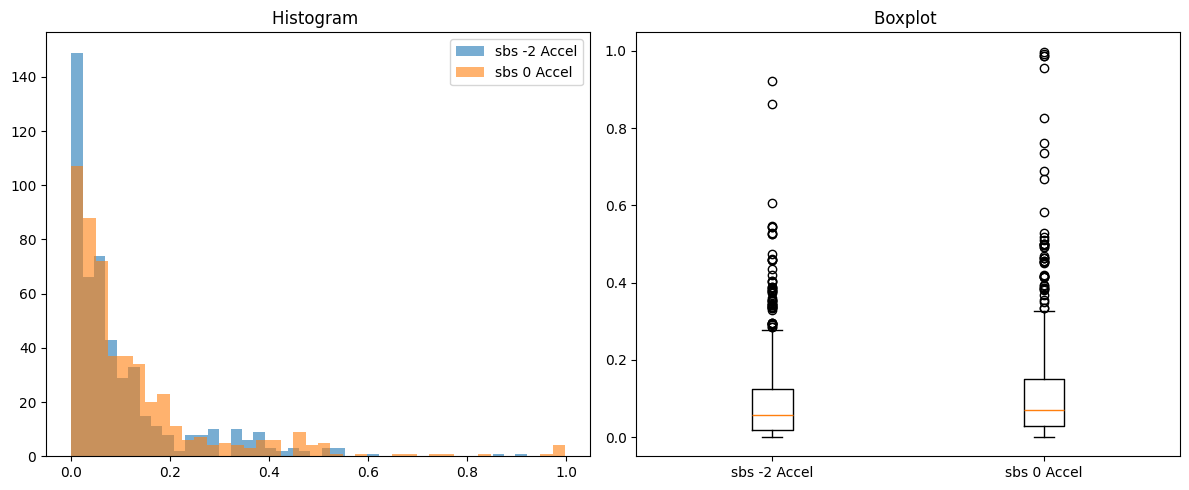

40320
Plotting differences for sbs -2 Accel vs sbs 1 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


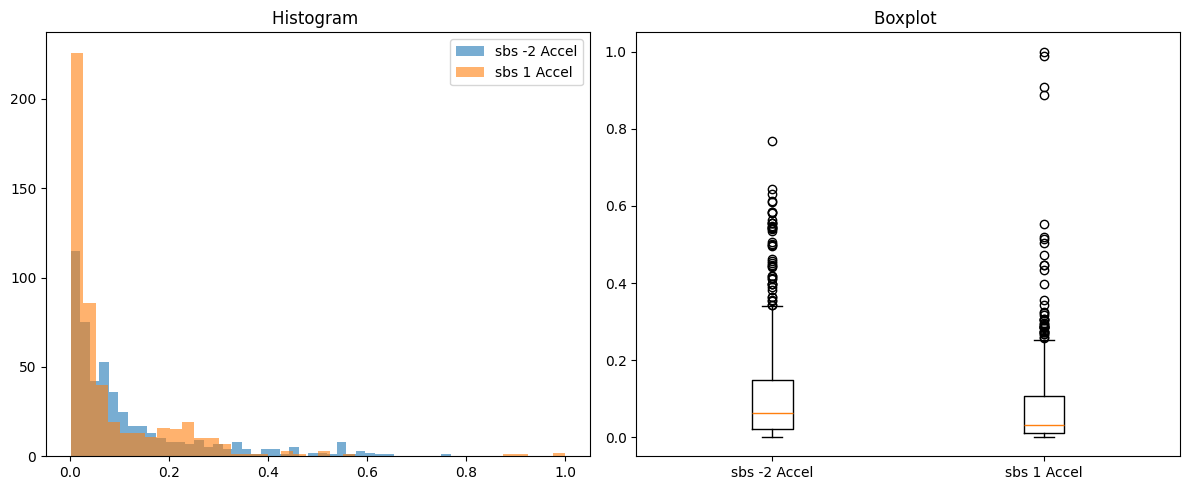

40320
32640
Plotting differences for sbs -1 Accel vs sbs 0 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


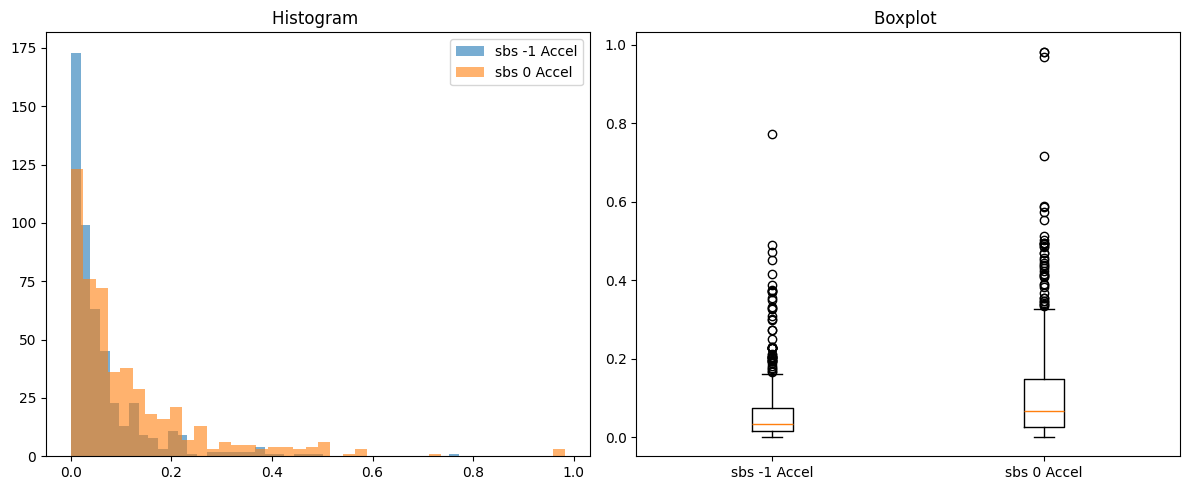

32640
Plotting differences for sbs -1 Accel vs sbs 1 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


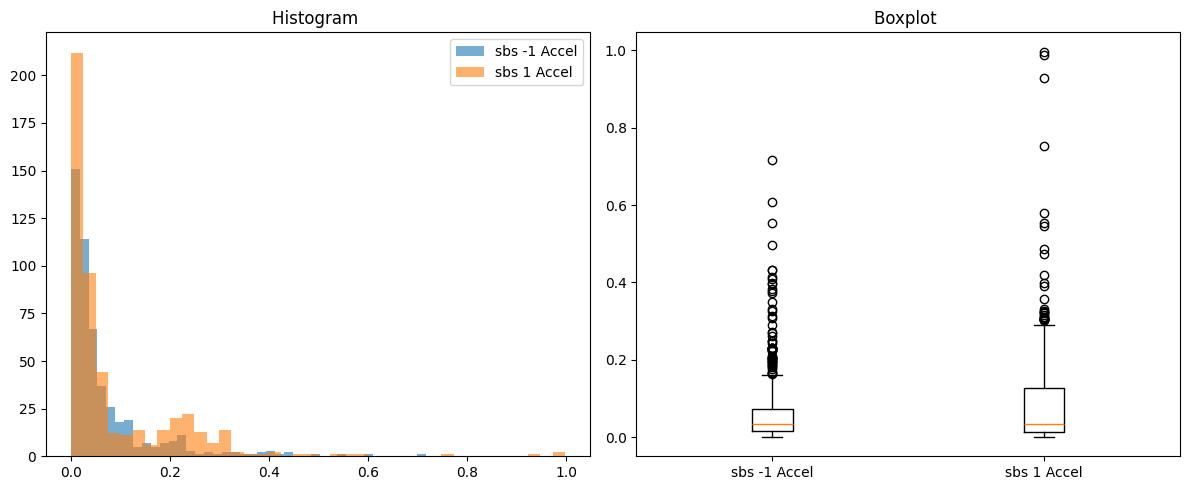

32640
184320
Plotting differences for sbs 0 Accel vs sbs 1 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


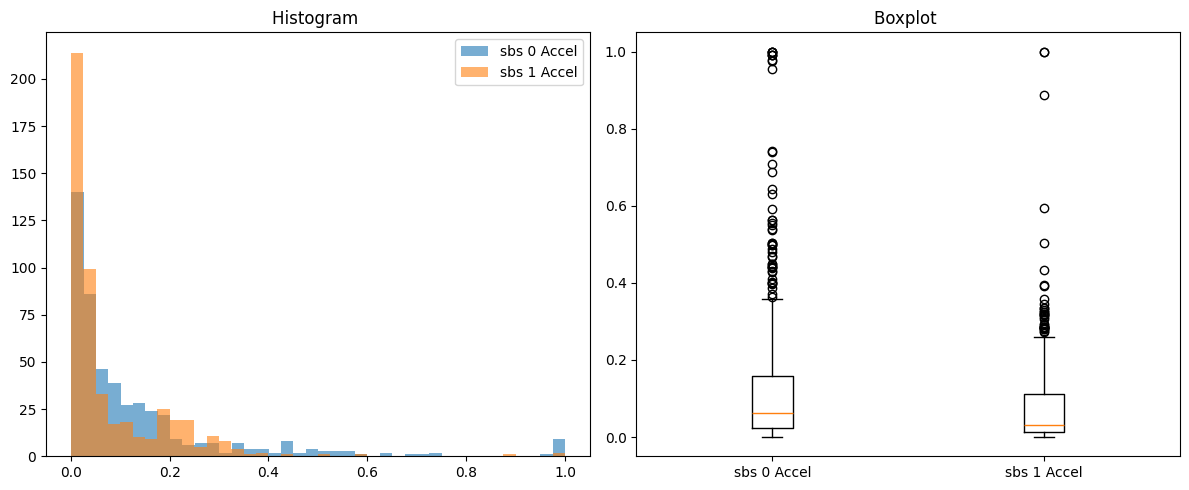

184320
3840


In [ ]:
SBS_hr_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
SBS_rr_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
SBS_accel_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}

# all SBS keys
sbs_keys = [-3, -2, -1, 0, 1, 2]

for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        # data_filepath_accel = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN_Validated.mat')           
        # data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{slice_size_min - lead_time}MIN_{lead_time}MIN_{Tag}.mat')
        data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN_{Tag}.mat')

        try:
            data = loadmat(data_filepath)
            x_mag = data["x_mag"]
            SBS = data["sbs"].flatten()
            
            hr = data['heart_rate']
            SpO2 = data['SpO2']
            rr = data['respiratory_rate']

            for i, sbs in enumerate(SBS):
                sbs = int(sbs)

                # extract raw arrays
                hr_data = hr[i].flatten()
                rr_data = rr[i].flatten()

                # skip bad rows
                if (np.mean(hr_data) == 0) or (np.mean(rr_data) == 0):
                    continue

                hr_min, hr_max = hr_data.min(), hr_data.max()
                hr_norm = (hr_data - hr_min) / (hr_max - hr_min)

                rr_min, rr_max = rr_data.min(), rr_data.max()
                rr_norm = (rr_data - rr_min) / (rr_max - rr_min)

                mad = Actigraph_Metrics.VecMag_MAD(x_mag[i, :], window_size)
                mad = np.array(mad).flatten()
                mad_min, mad_max = mad.min(), mad.max()
                mad_norm = (mad - mad_min) / (mad_max - mad_min)

                SBS_hr_dict[sbs].extend(hr_norm.tolist())
                SBS_rr_dict[sbs].extend(rr_norm.tolist())
                SBS_accel_dict[sbs].extend(mad_norm.tolist())

        except: 
            print(f'skipping patient {patient} due to load error.')
            continue
    
# metrics dicts
metrics = {
    "HR": SBS_hr_dict,
    "RR": SBS_rr_dict,
    "Accel": SBS_accel_dict
}

# iterate over all pairs of SBS keys
for metric_name, metric_dict in metrics.items():
    for sbs1, sbs2 in itertools.combinations(sbs_keys, 2):
        if sbs1 != sbs2:
            data1 = metric_dict[sbs1]

            data2 = metric_dict[sbs2]
            # call your compare_data function
            significant_differences = compare_data(
                data1, f'sbs {sbs1} {metric_name}',
                data2, f'sbs {sbs2} {metric_name}'
        
    )

In [65]:
#data_dir = 'C:/Users/sidha/OneDrive/Sid_stuff/PROJECTS/PedAccel/data_analysis/Vitals_accel_analysis/PatientData'
data_dir = Path('/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/Ventilated_Patient_Data')
data_dir = Path('/Users/jakehoffmann/Documents/JHU_Research/DT 6 Sedation/PatientData_Directory_To_Have_NEW 3')
window_size = 100 #100 is 1 second worth of time
lead_time = 1
slice_size_min = 16
sr = .5
Tag = 'Nurse'

/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/1520194242.py:40: RuntimeWarning: invalid value encountered in divide
  rr_norm = (rr_data - rr_min) / (rr_max - rr_min)


Plotting differences for sbs -1 HR vs sbs 1 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


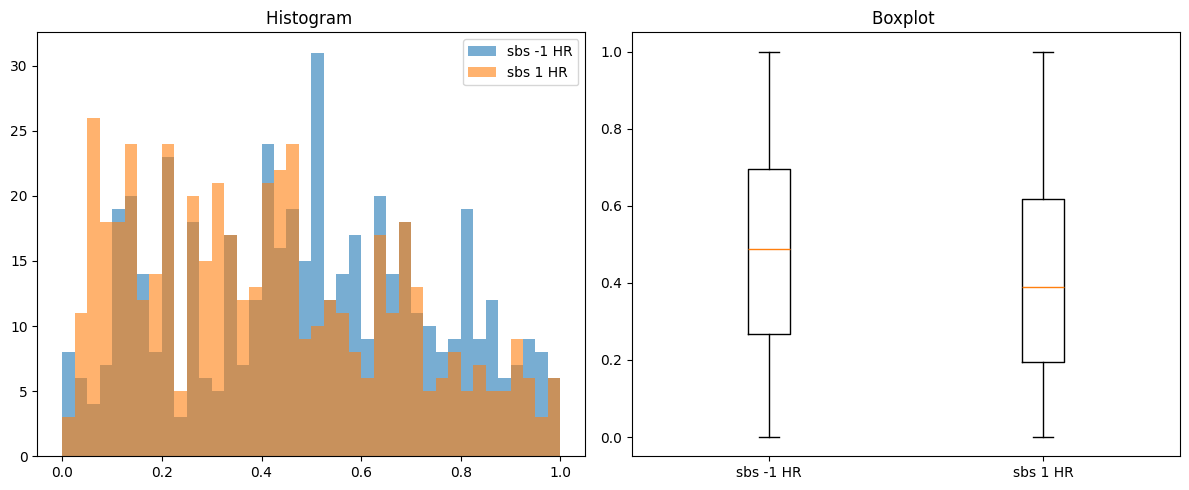

Plotting differences for sbs -1 HR vs sbs 2 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


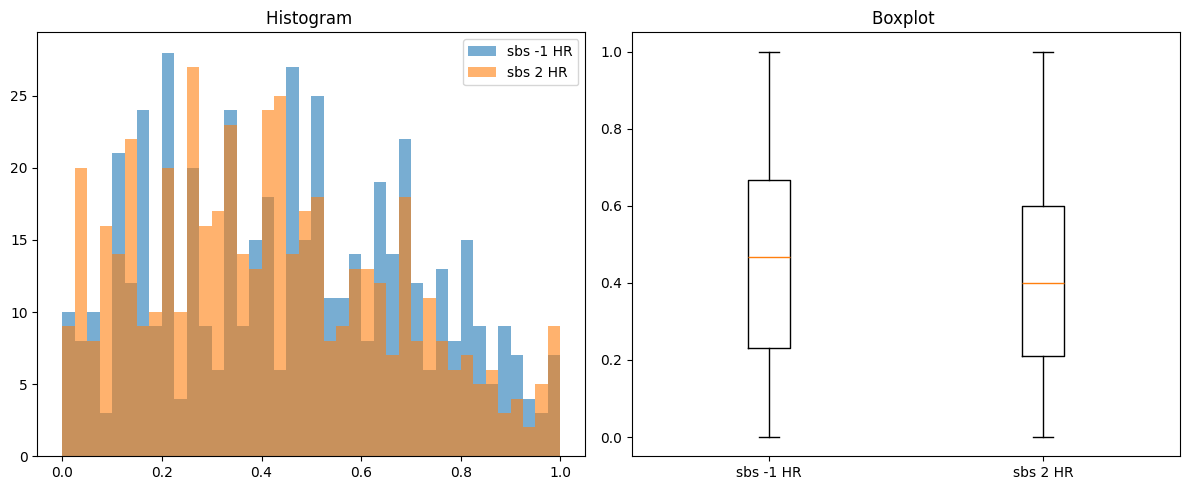

Plotting differences for sbs 0 HR vs sbs 2 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


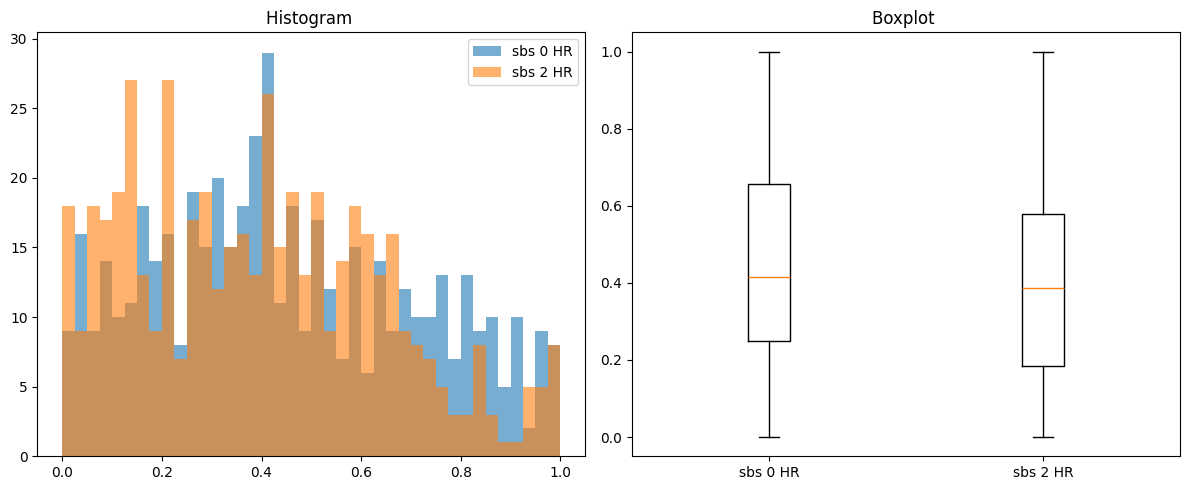

Plotting differences for sbs 1 HR vs sbs 2 HR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


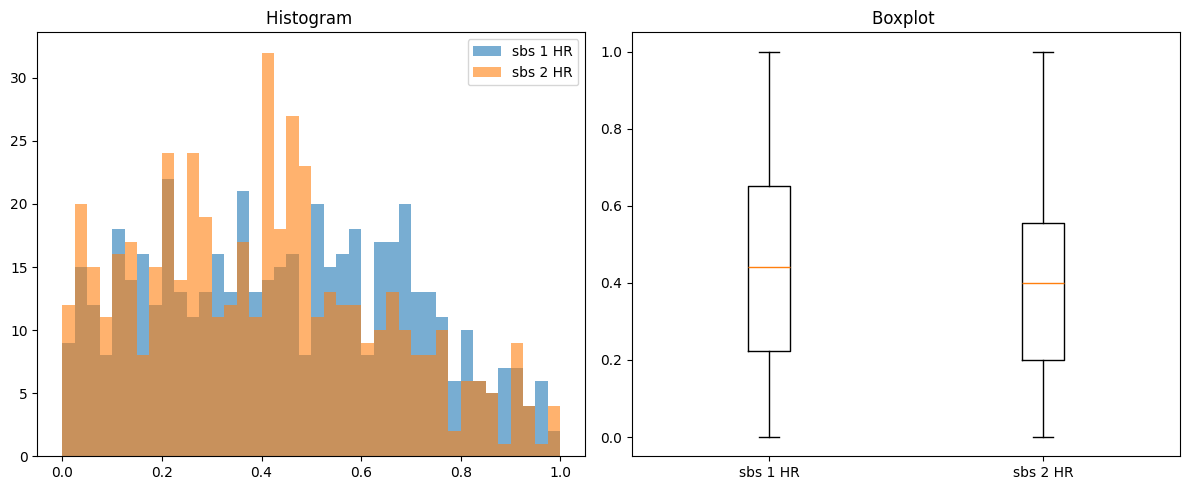

Plotting differences for sbs 0 RR vs sbs 1 RR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


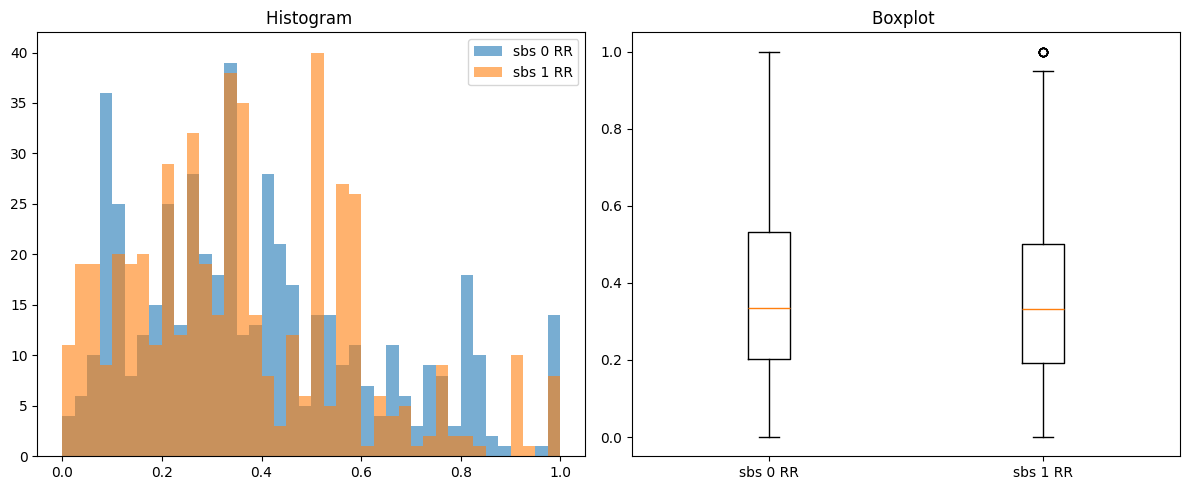

Plotting differences for sbs 0 RR vs sbs 2 RR...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


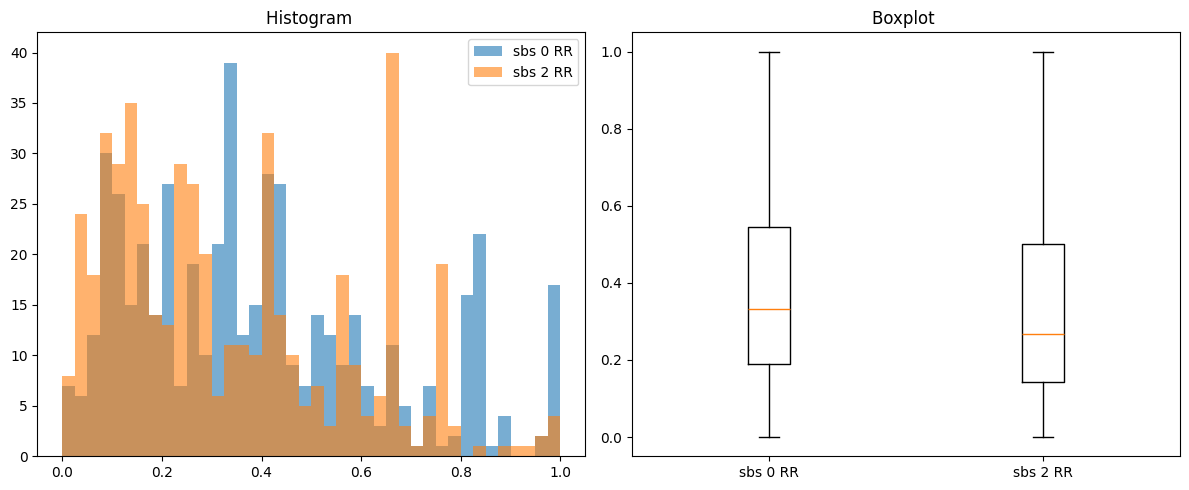

Plotting differences for sbs -1 Accel vs sbs 0 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


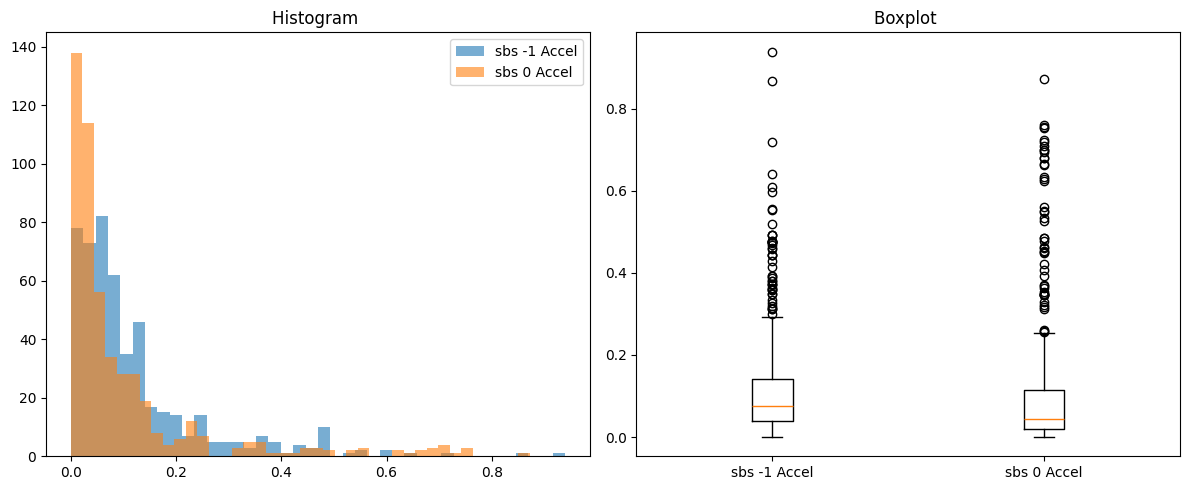

Plotting differences for sbs -1 Accel vs sbs 1 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


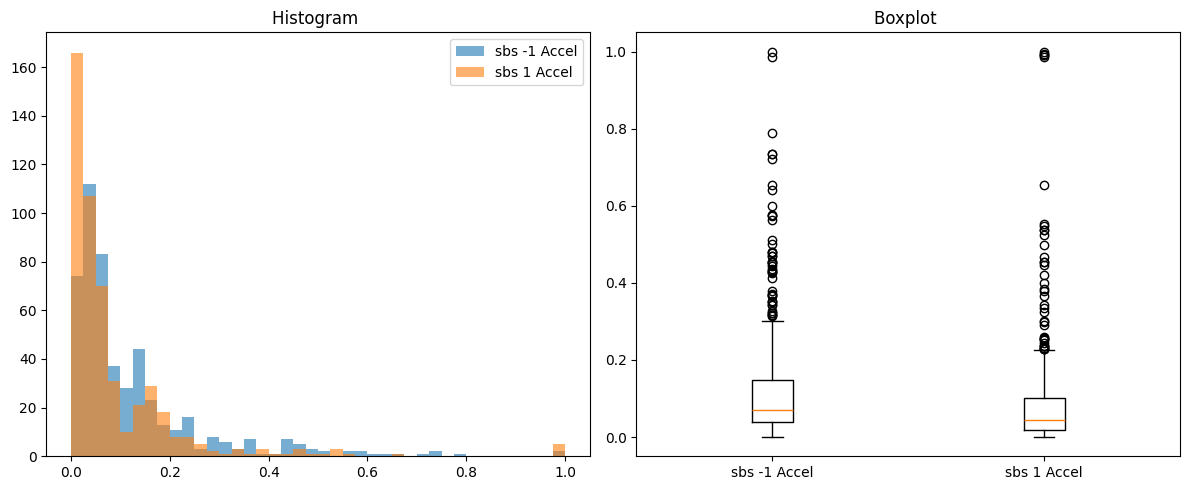

Plotting differences for sbs -1 Accel vs sbs 2 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


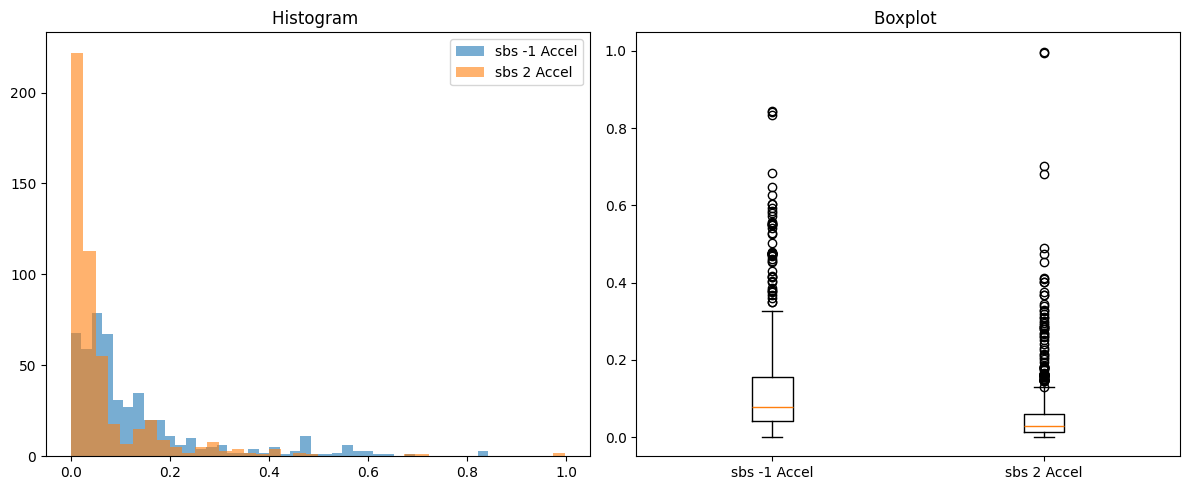

Plotting differences for sbs 0 Accel vs sbs 2 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


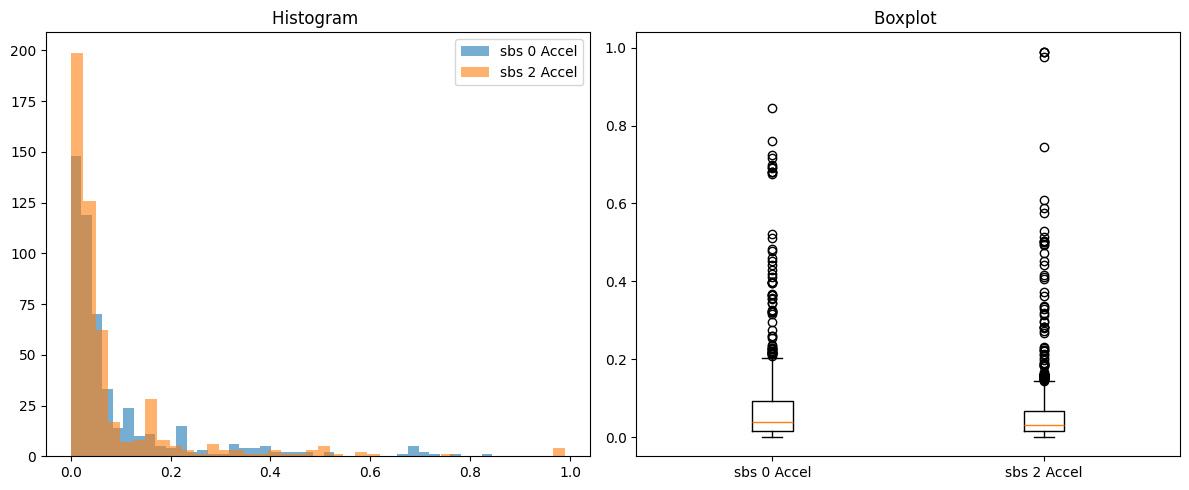

Plotting differences for sbs 1 Accel vs sbs 2 Accel...


/var/folders/5p/156pd2n9725b58sg8kk5wwv40000gn/T/ipykernel_46112/2880568388.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([data_1, data_2], labels=[label_1, label_2])


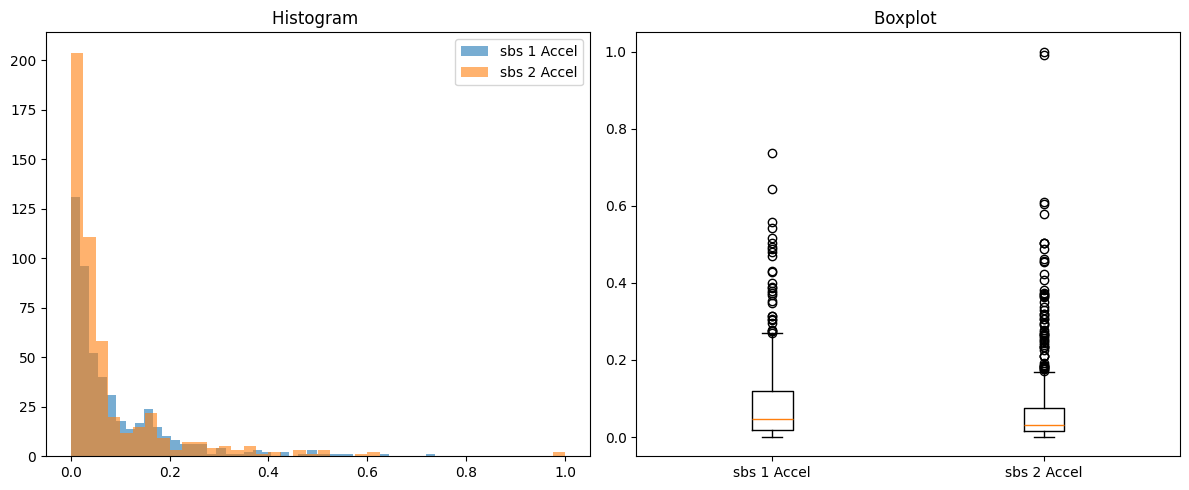

In [67]:
SBS_hr_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
SBS_rr_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}
SBS_accel_dict = {-3: [], -2: [], -1: [], 0: [], 1: [], 2: []}

# all SBS keys
sbs_keys = [-3, -2, -1, 0, 1, 2]

for patient in os.listdir(data_dir):
    # filter out non-directories
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        # data_filepath_accel = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN_Validated.mat')           
        # data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{slice_size_min - lead_time}MIN_{lead_time}MIN_{Tag}.mat')
        data_filepath = os.path.join(patient_dir, f'{patient}_SICKBAY_{slice_size_min - lead_time}MIN_{lead_time}MIN{Tag}.mat')

        try:
            data = loadmat(data_filepath)
            x_mag = data["x_mag"]
            SBS = data["sbs"].flatten()
            
            hr = data['heart_rate']
            SpO2 = data['SpO2']
            rr = data['respiratory_rate']

            for i, sbs in enumerate(SBS):
                sbs = int(sbs)

                # extract raw arrays
                hr_data = hr[i].flatten()
                rr_data = rr[i].flatten()

                # skip bad rows
                if (np.mean(hr_data) == 0) or (np.mean(rr_data) == 0):
                    continue

                hr_min, hr_max = hr_data.min(), hr_data.max()
                hr_norm = (hr_data - hr_min) / (hr_max - hr_min)

                rr_min, rr_max = rr_data.min(), rr_data.max()
                rr_norm = (rr_data - rr_min) / (rr_max - rr_min)

                mad = Actigraph_Metrics.VecMag_MAD(x_mag[i, :], window_size)
                mad = np.array(mad).flatten()
                mad_min, mad_max = mad.min(), mad.max()
                mad_norm = (mad - mad_min) / (mad_max - mad_min)

                SBS_hr_dict[sbs].extend(hr_norm.tolist())
                SBS_rr_dict[sbs].extend(rr_norm.tolist())
                SBS_accel_dict[sbs].extend(mad_norm.tolist())

        except: 
            print(f'skipping patient {patient} due to load error.')
            continue
    
# metrics dicts
metrics = {
    "HR": SBS_hr_dict,
    "RR": SBS_rr_dict,
    "Accel": SBS_accel_dict
}

# iterate over all pairs of SBS keys
for metric_name, metric_dict in metrics.items():
    for sbs1, sbs2 in itertools.combinations(sbs_keys, 2):
        if sbs1 != sbs2:
            data1 = metric_dict[sbs1]

            data2 = metric_dict[sbs2]
            # call your compare_data function
            significant_differences = compare_data(
                data1, f'sbs {sbs1} {metric_name}',
                data2, f'sbs {sbs2} {metric_name}'
        
    )